Epoch 1/15


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 167.0938 - mean_absolute_percentage_error: 80.8773 - val_loss: 40.3712 - val_mean_absolute_percentage_error: 25.2584 - learning_rate: 0.0010
Epoch 2/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 42.8392 - mean_absolute_percentage_error: 24.5822 - val_loss: 33.6001 - val_mean_absolute_percentage_error: 20.6159 - learning_rate: 0.0010
Epoch 3/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 38.6195 - mean_absolute_percentage_error: 21.7463 - val_loss: 35.2744 - val_mean_absolute_percentage_error: 20.8213 - learning_rate: 0.0010
Epoch 4/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 36.8646 - mean_absolute_percentage_error: 20.0811 - val_loss: 33.5493 - val_mean_absolute_percentage_error: 20.0808 - learning_rate: 0.0010
Epoch 5/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 37.5926 - mean_absolute_percentage_error: 20.1824 - val_loss: 33.1600 - val_mean_absolute_percentage_error: 19.5678 - learning_rate: 0.0010
Epoch 6/15

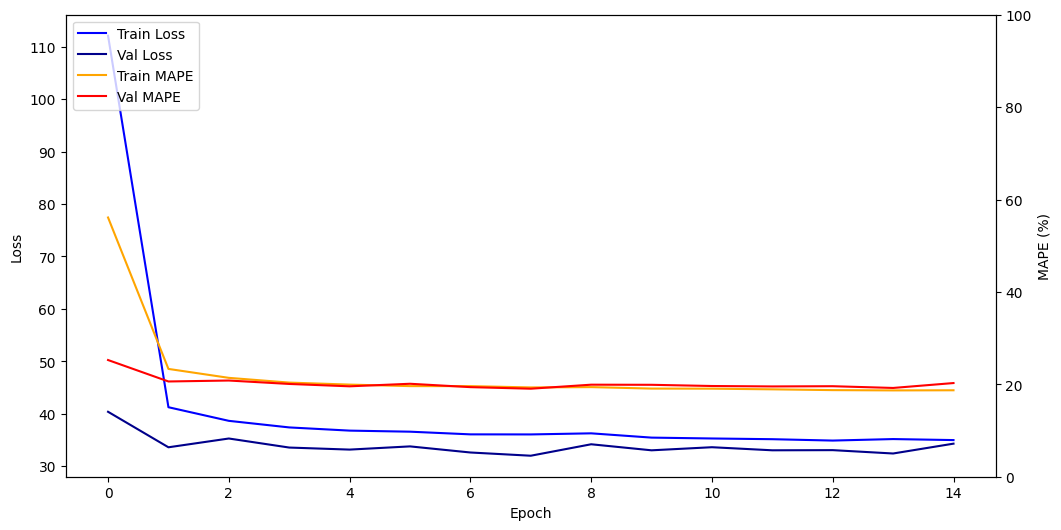

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

MAPE by Warengruppe:
Warengruppe 2: 13.81%
Warengruppe 5: 14.86%
Warengruppe 3: 18.97%
Warengruppe 1: 19.28%
Warengruppe 4: 24.74%
Warengruppe 6: 42.45%
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/tmp/ipykernel_24568/3244548428.py:171: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_by_group = results_df.groupby('Warengruppe').apply(


In [ ]:
'''

This version adds:

- Cyclical month encoding
- Peak season interaction features
- Higher weights for Warengruppe 6 peak periods
- Huber loss for outlier robustness

'''

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Load data
kiwo_url = '../../Data/kiwo.csv'
umsatz_url = '../../Data/train.csv'
wetter_url = '../../Data/wetter.csv'
test_url = '../../Data/test.csv'

df_kiwo = pd.read_csv(kiwo_url)
df_umsatz = pd.read_csv(umsatz_url)
df_wetter = pd.read_csv(wetter_url)
df_test = pd.read_csv(test_url)

# Merge data
df_train = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')
df_train = pd.merge(df_train, df_kiwo, on='Datum', how='left')
df_test = pd.merge(df_test, df_wetter, on='Datum', how='left')
df_test = pd.merge(df_test, df_kiwo, on='Datum', how='left')

def prepare_data(data):
    data['Datum'] = pd.to_datetime(data['Datum'])
    data['DayOfWeek'] = data['Datum'].dt.dayofweek
    data['Month'] = data['Datum'].dt.month
    data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(float)
    data['KielerWoche'] = data['KielerWoche'].fillna(0).astype(float)
    
    # Add seasonal features
    peak_months = [7, 8, 12]
    data['IsPeakSeason'] = data['Month'].isin(peak_months).astype(float)
    data['MonthSineCurve'] = np.sin(2 * np.pi * data['Month']/12)
    data['MonthCosineCurve'] = np.cos(2 * np.pi * data['Month']/12)
    
    numerical_cols = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode', 
                     'IsWeekend', 'IsPeakSeason', 'MonthSineCurve', 'MonthCosineCurve']
    
    knn_imputer = KNNImputer(n_neighbors=5)
    data[numerical_cols] = knn_imputer.fit_transform(data[numerical_cols])
    
    # Create interaction features for Warengruppe 6
    warengruppe_dummies = pd.get_dummies(data['Warengruppe'], prefix='Warengruppe')
    data['Warengruppe6_Peak'] = (data['Warengruppe'] == 6) * data['IsPeakSeason']
    data['Warengruppe6_Temp'] = (data['Warengruppe'] == 6) * data['Temperatur']
    
    feature_df = pd.concat([
        data[numerical_cols],
        warengruppe_dummies,
        pd.get_dummies(data['DayOfWeek'], prefix='Day'),
        pd.get_dummies(data['Month'], prefix='Month')
    ], axis=1)
    
    return feature_df

# Prepare datasets
df_train_sorted = df_train.sort_values(by='Datum')
X_train = prepare_data(df_train_sorted)
y_train = df_train_sorted['Umsatz']
X_test = prepare_data(df_test)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split data
split_index = int(len(X_train) * 0.8)
X_train_seq, X_val_seq = X_train[:split_index], X_train[split_index:]
y_train_seq, y_val_seq = y_train[:split_index], y_train[split_index:]

# Reshape for LSTM
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], 1, X_train_seq.shape[1])
X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], 1, X_val_seq.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                initializer='normal')
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W))
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Learning rate scheduler
def seasonal_lr_schedule(epoch, lr):
    if epoch < 50:
        return 0.001
    return 0.001 * tf.math.exp(-0.1 * ((epoch-50) // 10))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = LearningRateScheduler(seasonal_lr_schedule)

# Sample weights
sample_weights = df_train_sorted.apply(
    lambda row: 2.0 if row['Warengruppe'] == 6 and row['Month'] in [7, 8, 12] else 1.0,
    axis=1
)

# Build model
model = tf.keras.Sequential([
    LSTM(128, activation='relu', return_sequences=True, 
         input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    AttentionLayer(),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='huber',
             metrics=['mean_absolute_percentage_error'])

# Train model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    sample_weight=sample_weights[:split_index],
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

# Plot training history
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(history.history['loss'], label='Train Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Val Loss', color='darkblue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.plot(history.history['mean_absolute_percentage_error'], label='Train MAPE', color='orange')
ax2.plot(history.history['val_mean_absolute_percentage_error'], label='Val MAPE', color='red')
ax2.set_ylabel('MAPE (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 100)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.show()

# Load best model and evaluate
model.load_weights('best_model.keras')
val_predictions = model.predict(X_val_seq).flatten()

# Calculate MAPE by Warengruppe
val_warengruppen = df_train_sorted.iloc[split_index:]['Warengruppe']
results_df = pd.DataFrame({
    'Warengruppe': val_warengruppen,
    'Actual': y_val_seq,
    'Predicted': val_predictions
})

mape_by_group = results_df.groupby('Warengruppe').apply(
    lambda x: tf.keras.metrics.MeanAbsolutePercentageError()(x['Actual'], x['Predicted']).numpy()
).sort_values()

print("\nMAPE by Warengruppe:")
for warengruppe, mape in mape_by_group.items():
    print(f"Warengruppe {warengruppe}: {mape:.2f}%")

# Make predictions on test set
test_predictions = model.predict(X_test).flatten()
df_test['Predicted_Umsatz'] = test_predictions
df_test.to_csv('predicted_test.csv', index=False)